In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose,MaxPool2D
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab
from skimage.io import imsave
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import warnings
warnings.filterwarnings('ignore')

% matplotlib inline

#PATH of the project folder
PROJECT_ROOT_DIR=os.getcwd()

#Create Images folder
IMAGES_PATH=os.path.join(PROJECT_ROOT_DIR,"Images")
if not os.path.exists(IMAGES_PATH):
    os.makedirs(IMAGES_PATH)

#Function to save figures in the images folder
def save_fig(fig_id, tight_layout=True):
    path = os.path.join(IMAGES_PATH, fig_id + ".png")
    print("Figure {} saved".format(fig_id))
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)
    
#THRESHOLD for Other function
THRESHOLD=300



Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
train_dir='/content/drive/My Drive/Pictures_Portrait/train/'
val_dir='/content/drive/My Drive/Pictures_Portrait/val/'
test_dir='/content/drive/My Drive/Pictures_Portrait/test/'

In [0]:
train_dir

In [0]:
def image_random(nbr_img):
    name_image=[]
    nbr_index=[]
    for i in range(nbr_img):
        unique=True
        path = train_dir
        files = [f for f in os.listdir(path) if not f.startswith('.')]
        while unique:
            index = random.randrange(0, len(files))
            if index not in nbr_index:
                nbr_index.append(index)
                unique=False
        name_image.append(files[index])
    return name_image

In [0]:
random_image=image_random(5)

In [0]:
def visualization_image(files,sizeh,sizev):
    length=len(files)
    plt.figure(figsize=(sizeh,sizev))
    for each in range(len(files)):
        plt.subplot(1,length,each+1)
        imgplot=mpimg.imread(train_dir+files[each])
        plt.imshow(imgplot)
        plt.title('{}'.format(files[each],size=14))
    plt.tight_layout()
    save_fig('Random_Images')
    plt.show()

In [0]:
visualization_image(random_image,10,10)

In [0]:
# Get images
X_train = []
itr=0
for filename in os.listdir(train_dir):
    X_train.append(img_to_array(load_img(train_dir+filename)))
    itr+=1
    print('Image N {} loaded'.format(itr))
X_train = np.array(X_train, dtype=float)

In [0]:
# Get images
X_val = []
itr=0
for filename in os.listdir(val_dir):
    X_val.append(img_to_array(load_img(val_dir+filename)))
    itr+=1
    print('Image N {} loaded'.format(itr))
X_val = np.array(X_val, dtype=float)

In [0]:
X_train = 1.0/255*X_train
X_val = 1.0/255*X_val

In [0]:
X_train.shape

(5000, 128, 128, 3)

In [0]:
# Image transformer
train_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)
val_datagen=ImageDataGenerator()
# Generate training data
def image_a_b_gen(X,batch_size,gen):
    for batch in gen.flow(X, batch_size=batch_size):
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        Y_batch = lab_batch[:,:,:,1:] / 128
        X_batch = X_batch.reshape(X_batch.shape+(1,))
        yield (X_batch, Y_batch)

In [0]:
train_length=len([f for f in os.listdir(train_dir) if not f.startswith('.')])
val_length=len([f for f in os.listdir(val_dir) if not f.startswith('.')])

In [0]:
steps_train=np.ceil(train_length/16)
steps_val=np.ceil(val_length/16)

In [0]:
steps_train,steps_val

(313.0, 32.0)

In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

In [0]:
model = Sequential()
#model.add(InputLayer(input_shape=(None, None, 1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same',input_shape=(None,None,1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.compile(optimizer='rmsprop', loss='mse')

In [0]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_122 (Conv2D)          (None, None, None, 64)    640       
_________________________________________________________________
conv2d_123 (Conv2D)          (None, None, None, 64)    36928     
_________________________________________________________________
conv2d_124 (Conv2D)          (None, None, None, 128)   73856     
_________________________________________________________________
conv2d_125 (Conv2D)          (None, None, None, 128)   147584    
_________________________________________________________________
conv2d_126 (Conv2D)          (None, None, None, 256)   295168    
_________________________________________________________________
conv2d_127 (Conv2D)          (None, None, None, 256)   590080    
_________________________________________________________________
conv2d_128 (Conv2D)          (None, None, None, 512) 

In [0]:
# Train model      
history=model.fit_generator(   
    image_a_b_gen(X_train,16,train_datagen),
    steps_per_epoch=steps_train,
    epochs=150,
    validation_data=image_a_b_gen(X_val,16,val_datagen),
    validation_steps=steps_val,
    callbacks=[es, mc]
    )

Epoch 1/150
313/313 [==============================] - 42s 135ms/step - loss: 0.0290 - val_loss: 0.0094

Epoch 00001: val_loss improved from inf to 0.00940, saving model to best_model.h5
Epoch 2/150
313/313 [==============================] - 39s 125ms/step - loss: 0.0096 - val_loss: 0.0091

Epoch 00002: val_loss improved from 0.00940 to 0.00911, saving model to best_model.h5
Epoch 3/150
313/313 [==============================] - 39s 126ms/step - loss: 0.0092 - val_loss: 0.0090

Epoch 00003: val_loss improved from 0.00911 to 0.00897, saving model to best_model.h5
Epoch 4/150
313/313 [==============================] - 39s 125ms/step - loss: 0.0092 - val_loss: 0.0088

Epoch 00004: val_loss improved from 0.00897 to 0.00882, saving model to best_model.h5
Epoch 5/150
313/313 [==============================] - 39s 126ms/step - loss: 0.0091 - val_loss: 0.0089

Epoch 00005: val_loss did not improve from 0.00882
Epoch 6/150
313/313 [==============================] - 39s 126ms/step - loss: 0.0090

In [0]:
def plot_training(history):
    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs=range(1,len(loss)+1)

    plt.plot(epochs,loss,'bo',label='Training loss')
    plt.plot(epochs,val_loss,'b',label='Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()

    plt.show()

In [0]:
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'loss'])


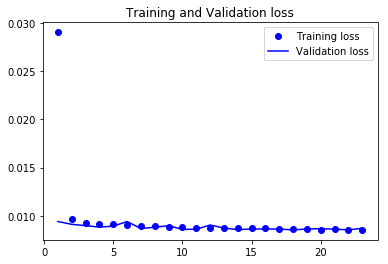

In [0]:
plot_training(history)

In [0]:
model.save('colorful_model.h5')

In [0]:
color_me = []
for filename in os.listdir(test_dir):
    color_me.append(img_to_array(load_img(test_dir+filename)))
color_me = np.array(color_me, dtype=float)
color_me = rgb2lab(1.0/255*color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape+(1,))

# Test model
output = model.predict(color_me)
output = output * 128

In [0]:
RESULT_PATH=os.path.join(os.getcwd(),"result")
if not os.path.exists(RESULT_PATH):
    os.makedirs(RESULT_PATH)

In [0]:
# Output colorizations
for i in range(len(output)):
    h,w,_=output[i].shape
    cur = np.zeros((h, w, 3))
    cur[:,:,0] = color_me[i][:,:,0]
    cur[:,:,1:] = output[i]
    imsave("result/img_"+str(i)+".png", lab2rgb(cur))

In [0]:
from math import ceil, log, floor
def closest_power(x):
    up=abs(np.power(2,ceil(log(x,2)))-x)
    down=abs(np.power(2,floor(log(x,2)))-x)
    if up==min(down,up) and up!=down :
        value= np.power(2,ceil(log(x,2)))
    else:
        value= np.power(2,floor(log(x,2)))
    if value >256 :
        return 256
    else :
        return value


In [0]:
model=load_model('/content/drive/My Drive/colorful_model1.h5')

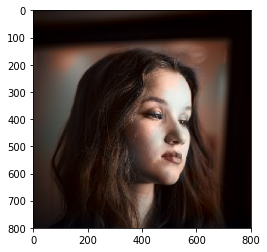

In [10]:
from PIL import Image
from skimage.transform import  resize

im = Image.open('Photo_test3.jpeg')
width, height = im.size
width_2=closest_power(width)
height_2=closest_power(height)
color_me=[]
color_me.append(img_to_array(load_img('Photo_test3.jpeg',target_size=(width_2,height_2))))

#color_me[i]=cv2.resize(color_me[i],(1024,1024))
color_me = np.array(color_me, dtype=float)
color_me = rgb2lab(1.0/255*color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape+(1,))
output = model.predict(color_me)
output = output * 128
for i in range(len(output)):
    cur = np.zeros((width_2, height_2, 3))
    cur[:,:,0] = color_me[i][:,:,0]
    cur[:,:,1:] = output[i]
    cur=resize(cur,(height,width))
plt.imshow(lab2rgb(cur))

In [11]:
imsave('After_Photo.png',lab2rgb(cur))